<a href="https://colab.research.google.com/github/Jorge-Calderon21/challenge-data-science_TelecomX/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [21]:
import json
import pandas as pd
import os

# Ruta a tu archivo JSON
json_path = "/content/sample_data/TelecomX_Data.json"

In [22]:
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)   # el archivo es una lista de dicts

# Aplana todas las claves anidadas usando '_' como separador
df_raw = pd.json_normalize(data, sep="_")
df_raw.head(3)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


In [23]:
rename_map = {
    "customerID": "customerid",
    "Churn": "churn",

    "customer_gender": "gender",
    "customer_SeniorCitizen": "seniorcitizen",
    "customer_Partner": "partner",
    "customer_Dependents": "dependents",
    "customer_tenure": "tenure",

    "phone_PhoneService": "phoneservice",
    "phone_MultipleLines": "multiplelines",

    "internet_InternetService": "internetservice",
    "internet_OnlineSecurity": "onlinesecurity",
    "internet_OnlineBackup": "onlinebackup",
    "internet_DeviceProtection": "deviceprotection",
    "internet_TechSupport": "techsupport",
    "internet_StreamingTV": "streamingtv",
    "internet_StreamingMovies": "streamingmovies",

    "account_Contract": "contract",
    "account_PaperlessBilling": "paperlessbilling",
    "account_PaymentMethod": "paymentmethod",
    "account_Charges_Monthly": "monthlycharges",
    "account_Charges_Total": "totalcharges",
}

df = df_raw.rename(columns=rename_map)

# Normaliza nombres (por si queda algún residuo no renombrado)
df.columns = (
    pd.Index(df.columns)
      .str.strip()
      .str.replace(r"\s+", "_", regex=True)
      .str.replace("-", "_")
      .str.replace("/", "_")
      .str.lower()
)

df.head(3)


,customerid,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


#🔧 Transformación

In [24]:
import numpy as np

# Cardinalidad por columna
card = df.nunique().sort_values(ascending=False).to_frame("unique_count")
display(card)

# Chequeo de la variable objetivo
if 'churn_flag' not in df.columns and 'churn' in df.columns:
    df['churn_flag'] = df['churn'].astype(str).str.upper().map({'YES':1,'NO':0}).fillna(0).astype(int)

print("Churn rate global:", df['churn_flag'].mean() if 'churn_flag' in df.columns else "No encontrado")

,unique_count
customerid,7267
totalcharges,6531
monthlycharges,1585
tenure,73
paymentmethod,4
contract,3
streamingmovies,3
deviceprotection,3
churn,3
onlinebackup,3


Churn rate global: 0.257190037154259


In [28]:
import os, re, json, pandas as pd, numpy as np

# --- util ---
def _normalize_colnames(cols):
    return (pd.Index(cols)
            .str.strip()
            .str.replace(r"\s+", "_", regex=True)
            .str.replace("-", "_")
            .str.replace("/", "_")
            .str.lower())

def _read_md_table(path):
    # extrae la tabla Markdown más larga (líneas que empiezan con '|')
    lines = Path(path).read_text(encoding="utf-8").splitlines()
    blocks, buf = [], []
    for line in lines:
        if line.strip().startswith("|"):
            buf.append(line.strip().strip("|"))
        else:
            if buf: blocks.append(buf); buf=[]
    if buf: blocks.append(buf)
    if not blocks: return None

    tbl = max(blocks, key=len)
    split = lambda s: [c.strip().strip("`") for c in s.split("|")]
    rows = [split(r) for r in tbl]
    # quita la fila de alineación ---|:---:|--- si existe
    if len(rows) >= 2 and all(re.fullmatch(r":?-{3,}:?", (c or "")) for c in rows[1]):
        rows = [rows[0]] + rows[2:]
    headers = _normalize_colnames(rows[0])
    df = pd.DataFrame(rows[1:], columns=headers)
    return df

def _read_md_keyvalue(path):
    # soporta líneas tipo: "- columna: descripción" o "`col` - desc"
    pat = re.compile(r'^\s*[-*]?\s*`?([^`:\-|]+)`?\s*[:\-]\s*(.+)$')
    pairs = []
    for line in Path(path).read_text(encoding="utf-8").splitlines():
        m = pat.match(line.strip())
        if m:
            pairs.append((m.group(1).strip(), m.group(2).strip()))
    if not pairs:
        return None
    df = pd.DataFrame(pairs, columns=["col", "descripcion"])
    df["col"] = _normalize_colnames(df["col"])
    return df

from pathlib import Path
def load_dictionary(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        dd = pd.read_csv(path)
    elif ext == ".json":
        dd = pd.DataFrame(json.load(open(path, "r", encoding="utf-8")))
    elif ext in [".xls", ".xlsx"]:
        dd = pd.read_excel(path)
    elif ext == ".md":
        dd = _read_md_table(path) or _read_md_keyvalue(path)
        if dd is None:
            raise ValueError("No encontré tabla Markdown ni pares 'col: descripción' en el .md")
    else:
        raise ValueError(f"Extensión no soportada: {ext}")

    dd.columns = _normalize_colnames(dd.columns)
    # normaliza nombres canónicos
    col_key = next((c for c in ["col","column","columns","campo","feature","variable","nombre_columna","nombre"] if c in dd.columns), None)
    if col_key is None: col_key = dd.columns[0]
    dd = dd.rename(columns={col_key: "col"})
    if "descripcion" not in dd.columns:
        for cand in ["description","descripción","desc","detalle","meaning","definicion","definición"]:
            if cand in dd.columns:
                dd = dd.rename(columns={cand: "descripcion"})
                break
    if "descripcion" not in dd.columns:
        dd["descripcion"] = ""
    dd["col"] = _normalize_colnames(dd["col"])
    return dd

In [32]:
DICT_PATH = "/content/sample_data/TelecomX_diccionario.md"
dic = load_dictionary(DICT_PATH)

# perfila df y une con el diccionario
df.columns = _normalize_colnames(df.columns)
prof = pd.DataFrame({
    "col": df.columns,
    "dtype": [str(dt) for dt in df.dtypes],
    "missing_%": (df.isna().mean()*100).round(2).values,
    "unique_count": df.nunique().values
})
schema = prof.merge(dic, on="col", how="left").sort_values(["missing_%","unique_count"], ascending=[False, True])
display(schema.head(30))

,col,dtype,missing_%,unique_count,descripcion
2,gender,object,0.0,2,género (masculino y femenino)
3,seniorcitizen,int64,0.0,2,información sobre si un cliente tiene o no una...
4,partner,object,0.0,2,si el cliente tiene o no una pareja
5,dependents,object,0.0,2,si el cliente tiene o no dependientes
7,phoneservice,object,0.0,2,suscripción al servicio telefónico
17,paperlessbilling,object,0.0,2,si el cliente prefiere recibir la factura en l...
21,churn_flag,int64,0.0,2,NaN
1,churn,object,0.0,3,si el cliente dejó o no la empresa
8,multiplelines,object,0.0,3,suscripción a más de una línea telefónica
9,internetservice,object,0.0,3,suscripción a un proveedor de internet


In [33]:
from sklearn.feature_selection import mutual_info_classif

# 1) Asegura variable objetivo binaria
if "churn_flag" not in df.columns and "churn" in df.columns:
    df["churn_flag"] = df["churn"].astype(str).str.upper().map({"YES":1,"NO":0}).fillna(0).astype(int)

y = df["churn_flag"].values

# 2) Definir columnas
id_cols = [c for c in ["customerid","id","customer_id"] if c in df.columns]
target_cols = ["churn","churn_flag"]
num_cols = df.select_dtypes(include=[np.number]).columns.drop(target_cols, errors="ignore").tolist()
cat_cols = [c for c in df.select_dtypes(include=["object"]).columns if c not in id_cols + target_cols]

num_cols, cat_cols

(['seniorcitizen', 'tenure', 'monthlycharges'],
 ['gender',
  'partner',
  'dependents',
  'phoneservice',
  'multiplelines',
  'internetservice',
  'onlinesecurity',
  'onlinebackup',
  'deviceprotection',
  'techsupport',
  'streamingtv',
  'streamingmovies',
  'contract',
  'paperlessbilling',
  'paymentmethod',
  'totalcharges'])

In [34]:
# diferencia entre la categoría con mayor churn y la de menor churn (mayor spread => más señal)
cat_rows=[]
for c in cat_cols:
    g = df.groupby(c, dropna=False)["churn_flag"].agg(["mean","count"]).rename(columns={"mean":"churn_rate"})
    if len(g) >= 2:
        spread = float(g["churn_rate"].max() - g["churn_rate"].min())
        top_level = g["churn_rate"].idxmax()
        top_rate  = float(g["churn_rate"].max())
        cat_rows.append((c, round(spread,4), len(g), str(top_level), round(top_rate,4)))
cat_rank = (
    pd.DataFrame(cat_rows, columns=["feature","churn_rate_spread","n_levels","top_level","top_level_rate"])
      .sort_values(["churn_rate_spread","n_levels"], ascending=[False, True])
      .reset_index(drop=True)
)
cat_rank.head(12)

,feature,churn_rate_spread,n_levels,top_level,top_level_rate
0,totalcharges,1.0000,6531,100.25,1.0000
1,contract,0.3857,3,Month-to-month,0.4132
2,internetservice,0.3341,3,Fiber optic,0.4056
3,onlinesecurity,0.3335,3,No,0.4049
4,techsupport,0.3322,3,No,0.4037
5,onlinebackup,0.3160,3,No,0.3875
6,deviceprotection,0.3076,3,No,0.3790
7,paymentmethod,0.2901,4,Electronic check,0.4380
8,streamingmovies,0.2554,3,No,0.3268
9,streamingtv,0.2538,3,No,0.3253


In [35]:
num_rank = (
    df[num_cols].corrwith(df["churn_flag"]).abs()
      .sort_values(ascending=False)
      .to_frame("abs_corr_with_churn")
)
num_rank.head(12)

,abs_corr_with_churn
tenure,0.344079
monthlycharges,0.189866
seniorcitizen,0.146733


In [36]:
# Categóricas → one-hot y agregamos MI por columna original
dummies = pd.get_dummies(df[cat_cols].fillna("NaN"), prefix=cat_cols, dummy_na=False)
mi_cat = mutual_info_classif(dummies, y, discrete_features=True, random_state=42)
mi_cat_series = pd.Series(mi_cat, index=dummies.columns)

# Agrupar por columna original (prefijo antes del primer "_")
mi_cat_agg = (
    mi_cat_series.groupby([c.split("_",1)[0] for c in mi_cat_series.index])
                 .sum()
                 .sort_values(ascending=False)
                 .to_frame("mutual_info")
)

# Numéricas → MI directa
X_num = df[num_cols].fillna(df[num_cols].median())
mi_num = mutual_info_classif(X_num, y, discrete_features=False, random_state=42)
mi_num_series = pd.Series(mi_num, index=num_cols).sort_values(ascending=False).to_frame("mutual_info")

mi_rank = pd.concat([mi_cat_agg, mi_num_series]).sort_values("mutual_info", ascending=False)
mi_rank.head(12)

,mutual_info
totalcharges,0.516617
contract,0.163047
onlinesecurity,0.104445
techsupport,0.101204
internetservice,0.083521
onlinebackup,0.068377
tenure,0.068076
deviceprotection,0.062972
paymentmethod,0.062500
monthlycharges,0.042906


In [37]:
TOP = 8
shortlist = (
    list(cat_rank.head(TOP)["feature"]) +
    list(num_rank.head(TOP).index) +
    list(mi_rank.head(TOP).index)
)
shortlist = pd.Series(shortlist).drop_duplicates().tolist()
shortlist


['totalcharges',
 'contract',
 'internetservice',
 'onlinesecurity',
 'techsupport',
 'onlinebackup',
 'deviceprotection',
 'paymentmethod',
 'tenure',
 'monthlycharges',
 'seniorcitizen']

In [38]:
if "churn_flag" not in df.columns and "churn" in df.columns:
    df["churn_flag"] = df["churn"].astype(str).str.upper().map({"YES":1,"NO":0}).fillna(0).astype(int)

print("Forma:", df.shape)
display(df.dtypes)

na_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False).to_frame("missing_%")
card = df.nunique().sort_values(ascending=False).to_frame("unique_count")
display(na_pct.head(20))
display(card.head(20))

Forma: (7267, 22)


,0
customerid,object
churn,object
gender,object
seniorcitizen,int64
partner,object
dependents,object
tenure,int64
phoneservice,object
multiplelines,object
internetservice,object


,missing_%
customerid,0.0
churn,0.0
gender,0.0
seniorcitizen,0.0
partner,0.0
dependents,0.0
tenure,0.0
phoneservice,0.0
multiplelines,0.0
internetservice,0.0


,unique_count
customerid,7267
totalcharges,6531
monthlycharges,1585
tenure,73
paymentmethod,4
churn,3
streamingmovies,3
techsupport,3
onlinebackup,3
streamingtv,3


In [39]:
id_cols = [c for c in ["customerid","customer_id","id"] if c in df.columns]
dupes_all = df[df.duplicated(keep=False)]  # duplicados exactos
print("Duplicados exactos:", len(dupes_all))

if id_cols:
    key = id_cols[0]
    dup_ids = df[df.duplicated(subset=[key], keep=False)].sort_values(key)
    print(f"Duplicados por {key}:", dup_ids[key].nunique(), "IDs")
    display(dup_ids.head(10))
else:
    print("No hay columna ID explícita detectada.")


Duplicados exactos: 0
Duplicados por customerid: 0 IDs


,customerid,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn_flag


In [40]:
# Columnas que deberían ser numéricas en tu esquema
expected_numeric = [c for c in ["monthlycharges","totalcharges","tenure","seniorcitizen"] if c in df.columns]

# Detecta numéricos guardados como 'object'
object_numeric = [c for c in expected_numeric if df[c].dtype == "object"]
print("Numéricos como texto:", object_numeric)

# Crea copia para pruebas de coerción
df_types = df.copy()
for c in expected_numeric:
    if c in df_types.columns:
        df_types[c] = pd.to_numeric(df_types[c], errors="coerce")

display(df_types[expected_numeric].describe(include="all"))

Numéricos como texto: ['totalcharges']


,monthlycharges,totalcharges,tenure,seniorcitizen
count,7267.000000,7256.000000,7267.000000,7267.000000
mean,64.720098,2280.634213,32.346498,0.162653
std,30.129572,2268.632997,24.571773,0.369074
min,18.250000,18.800000,0.000000,0.000000
25%,35.425000,400.225000,9.000000,0.000000
50%,70.300000,1391.000000,29.000000,0.000000
75%,89.875000,3785.300000,55.000000,0.000000
max,118.750000,8684.800000,72.000000,1.000000


In [41]:
# Candidatas categóricas principales
cat_candidates = [c for c in [
    "gender","partner","dependents","phoneservice","multiplelines","internetservice",
    "onlinesecurity","onlinebackup","deviceprotection","techsupport",
    "streamingtv","streamingmovies","contract","paperlessbilling","paymentmethod","churn"
] if c in df.columns]

def uniques_with_counts(s, top=50):
    return s.value_counts(dropna=False).head(top)

for c in cat_candidates:
    print(f"\n--- {c} ---")
    # Muestra valores crudos y valores strip/upper para detectar variantes
    display(uniques_with_counts(df[c]))
    display(uniques_with_counts(df[c].astype(str).str.strip()))



--- gender ---


,count
gender,
Male,3675
Female,3592


,count
gender,
Male,3675
Female,3592



--- partner ---


,count
partner,
No,3749
Yes,3518


,count
partner,
No,3749
Yes,3518



--- dependents ---


,count
dependents,
No,5086
Yes,2181


,count
dependents,
No,5086
Yes,2181



--- phoneservice ---


,count
phoneservice,
Yes,6560
No,707


,count
phoneservice,
Yes,6560
No,707



--- multiplelines ---


,count
multiplelines,
No,3495
Yes,3065
No phone service,707


,count
multiplelines,
No,3495
Yes,3065
No phone service,707



--- internetservice ---


,count
internetservice,
Fiber optic,3198
DSL,2488
No,1581


,count
internetservice,
Fiber optic,3198
DSL,2488
No,1581



--- onlinesecurity ---


,count
onlinesecurity,
No,3608
Yes,2078
No internet service,1581


,count
onlinesecurity,
No,3608
Yes,2078
No internet service,1581



--- onlinebackup ---


,count
onlinebackup,
No,3182
Yes,2504
No internet service,1581


,count
onlinebackup,
No,3182
Yes,2504
No internet service,1581



--- deviceprotection ---


,count
deviceprotection,
No,3195
Yes,2491
No internet service,1581


,count
deviceprotection,
No,3195
Yes,2491
No internet service,1581



--- techsupport ---


,count
techsupport,
No,3582
Yes,2104
No internet service,1581


,count
techsupport,
No,3582
Yes,2104
No internet service,1581



--- streamingtv ---


,count
streamingtv,
No,2896
Yes,2790
No internet service,1581


,count
streamingtv,
No,2896
Yes,2790
No internet service,1581



--- streamingmovies ---


,count
streamingmovies,
No,2870
Yes,2816
No internet service,1581


,count
streamingmovies,
No,2870
Yes,2816
No internet service,1581



--- contract ---


,count
contract,
Month-to-month,4005
Two year,1743
One year,1519


,count
contract,
Month-to-month,4005
Two year,1743
One year,1519



--- paperlessbilling ---


,count
paperlessbilling,
Yes,4311
No,2956


,count
paperlessbilling,
Yes,4311
No,2956



--- paymentmethod ---


,count
paymentmethod,
Electronic check,2445
Mailed check,1665
Bank transfer (automatic),1589
Credit card (automatic),1568


,count
paymentmethod,
Electronic check,2445
Mailed check,1665
Bank transfer (automatic),1589
Credit card (automatic),1568



--- churn ---


,count
churn,
No,5174
Yes,1869
,224


,count
churn,
No,5174
Yes,1869
,224


In [42]:
checks = {}

# 1) Si NO hay internet, no debería haber add-ons de internet
if "internetservice" in df.columns:
    internet_no = df["internetservice"].astype(str).str.lower().eq("no")
    internet_addons = [c for c in ["onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv","streamingmovies"] if c in df.columns]
    for c in internet_addons:
        bad = internet_no & df[c].astype(str).str.lower().isin(["yes"])
        checks[f"internet_no__but_{c}_yes"] = bad.sum()

# 2) Si NO hay phone service, multiplelines no debería ser "Yes"
if {"phoneservice","multiplelines"}.issubset(df.columns):
    phone_no_but_multi = df["phoneservice"].astype(str).str.lower().eq("no") & df["multiplelines"].astype(str).str.lower().eq("yes")
    checks["phoneservice_no__but_multiplelines_yes"] = phone_no_but_multi.sum()

# 3) Rangos básicos
if "tenure" in df.columns:
    checks["tenure_negative"] = (df_types["tenure"] < 0).sum()
    checks["tenure_gt_72"] = (df_types["tenure"] > 72).sum()
if "monthlycharges" in df.columns:
    checks["monthlycharges_negative"] = (df_types["monthlycharges"] < 0).sum()
if "totalcharges" in df.columns:
    checks["totalcharges_negative"] = (df_types["totalcharges"] < 0).sum()

# 4) Consistencia de facturación: gap entre total y mensual*tenure
if {"monthlycharges","tenure","totalcharges"}.issubset(df_types.columns):
    bill_gap = (df_types["totalcharges"] - df_types["monthlycharges"]*df_types["tenure"]).astype(float)
    df_types["bill_gap"] = bill_gap
    # Marca gaps "grandes" (umbral ajustable)
    checks["bill_gap_abs_gt_50"] = bill_gap.abs().gt(50).sum()

pd.Series(checks, name="violations").to_frame()


,violations
internet_no__but_onlinesecurity_yes,0
internet_no__but_onlinebackup_yes,0
internet_no__but_deviceprotection_yes,0
internet_no__but_techsupport_yes,0
internet_no__but_streamingtv_yes,0
internet_no__but_streamingmovies_yes,0
phoneservice_no__but_multiplelines_yes,0
tenure_negative,0
tenure_gt_72,0
monthlycharges_negative,0


In [43]:
num_cols = [c for c in df_types.select_dtypes(include=[np.number]).columns if c not in ["churn_flag"]]
outlier_report = []

for c in num_cols:
    s = df_types[c].dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = ((s < lo) | (s > hi)).sum()
    outlier_report.append((c, int(n_out), float(lo), float(hi)))

outliers_df = pd.DataFrame(outlier_report, columns=["col","outliers","low_bound","high_bound"]).sort_values("outliers", ascending=False)
outliers_df.head(10)

,col,outliers,low_bound,high_bound
0,seniorcitizen,1182,0.0000,0.0000
4,bill_gap,694,-114.4250,114.5750
1,tenure,0,-60.0000,124.0000
2,monthlycharges,0,-46.2500,171.5500
3,totalcharges,0,-4677.3875,8862.9125


In [44]:
df_clean = df.copy()

# 1) Normalizar strings Yes/No y quitar espacios
def norm_yn(s):
    return (s.astype(str)
              .str.strip()
              .str.replace(r"\s+", " ", regex=True)
              .str.title())  # "yes" -> "Yes", "no internet service" -> "No Internet Service"

yn_cols = [c for c in [
    "partner","dependents","phoneservice","multiplelines",
    "onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv","streamingmovies",
    "paperlessbilling","churn"
] if c in df_clean.columns]
for c in yn_cols:
    df_clean[c] = norm_yn(df_clean[c])

# 2) Coerción numérica
for c in ["monthlycharges","totalcharges","tenure","seniorcitizen"]:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

# 3) Normalizar categorías clave
if "internetservice" in df_clean.columns:
    df_clean["internetservice"] = (df_clean["internetservice"].astype(str)
                                   .str.strip().str.title())  # "fiber optic" -> "Fiber Optic", "dsl"->"Dsl"
    # Corrige casos sin internet: addons a "No Internet Service"
    no_inet = df_clean["internetservice"].str.lower().eq("no")
    for c in ["onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv","streamingmovies"]:
        if c in df_clean.columns:
            df_clean.loc[no_inet, c] = "No Internet Service"

# 4) Coherencia teléfono
if {"phoneservice","multiplelines"}.issubset(df_clean.columns):
    no_phone = df_clean["phoneservice"].str.lower().eq("no")
    df_clean.loc[no_phone, "multiplelines"] = "No Phone Service"

# 5) Límites suaves
if "tenure" in df_clean.columns:
    df_clean.loc[df_clean["tenure"] < 0, "tenure"] = np.nan
    # si tu negocio tiene máximo distinto a 72, ajusta aquí
    df_clean.loc[df_clean["tenure"] > 72, "tenure"] = 72

if "monthlycharges" in df_clean.columns:
    df_clean.loc[df_clean["monthlycharges"] < 0, "monthlycharges"] = np.nan
if "totalcharges" in df_clean.columns:
    df_clean.loc[df_clean["totalcharges"] < 0, "totalcharges"] = np.nan

# 6) Recalcular churn_flag
if "churn" in df_clean.columns:
    df_clean["churn_flag"] = df_clean["churn"].map({"Yes":1,"No":0}).astype("Int64")

# 7) Guardar
clean_path = "/content/sample_data/clientes_clean.csv"
df_clean.to_csv(clean_path, index=False)
clean_path

'/content/sample_data/clientes_clean.csv'

In [45]:
def clean_telecomx(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # --- A. Normalizar strings base (strip, espacios múltiples -> uno, NAs textuales) ---
    for c in df.select_dtypes(include=["object"]).columns:
        s = df[c].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
        s = s.replace({"": pd.NA, "nan": pd.NA, "none": pd.NA, "null": pd.NA}, regex=False)
        df[c] = s

    # --- B. Estándar Yes/No (lower->map->Title) ---
    def norm_yesno(s: pd.Series) -> pd.Series:
        raw = s.astype(str).str.strip().str.lower()
        mapped = raw.map({
            "y":"yes","yes":"yes","si":"yes","sí":"yes","true":"yes","t":"yes","1":"yes",
            "n":"no","no":"no","false":"no","f":"no","0":"no",
            "no internet service":"no internet service",
            "no phone service":"no phone service"
        }).fillna(raw)
        return mapped.replace({
            "yes":"Yes","no":"No",
            "no internet service":"No Internet Service",
            "no phone service":"No Phone Service"
        })

    yn_cols = [c for c in [
        "partner","dependents","phoneservice","multiplelines",
        "onlinesecurity","onlinebackup","deviceprotection","techsupport",
        "streamingtv","streamingmovies","paperlessbilling","churn"
    ] if c in df.columns]
    for c in yn_cols:
        df[c] = norm_yesno(df[c])

    # --- C. Normalizar categorías clave con contains/startswith ---
    if "internetservice" in df.columns:
        s = df["internetservice"].astype(str).str.lower().str.strip()
        df["internetservice"] = np.select(
            [s.str.contains("fiber"), s.str.startswith("dsl"), s.str.fullmatch("no")],
            ["Fiber optic", "DSL", "No"],
            default=df["internetservice"].astype(str).str.title()
        )

    if "contract" in df.columns:
        s = df["contract"].astype(str).str.lower().str.strip()
        df["contract"] = np.select(
            [s.str.contains("month"), s.str.contains("one"), s.str.contains("two")],
            ["Month-to-month", "One year", "Two year"],
            default=df["contract"].astype(str).str.title()
        )

    if "paymentmethod" in df.columns:
        s = df["paymentmethod"].astype(str).str.lower().str.strip()
        df["paymentmethod"] = np.select(
            [s.str.contains("electronic"), s.str.contains("mailed"),
             s.str.contains("bank transfer"), s.str.contains("credit card")],
            ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"],
            default=df["paymentmethod"].astype(str).str.title()
        )

    # --- D. Tipos numéricos (coerción robusta) ---
    for c in ["monthlycharges","totalcharges","tenure","seniorcitizen"]:
        if c in df.columns:
            df[c] = (df[c].astype(str)
                           .str.replace(",", "", regex=False)
                           .str.replace("$", "", regex=False))
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- E. Reglas de negocio / coherencia cruzada ---
    # 1) Sin internet -> addons = "No Internet Service"
    inet_addons = [c for c in ["onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv","streamingmovies"] if c in df.columns]
    if "internetservice" in df.columns and inet_addons:
        no_inet = df["internetservice"].eq("No")
        for c in inet_addons:
            df.loc[no_inet, c] = "No Internet Service"

    # 2) Sin phone service -> multiplelines = "No Phone Service"
    if {"phoneservice","multiplelines"}.issubset(df.columns):
        no_phone = df["phoneservice"].eq("No")
        df.loc[no_phone, "multiplelines"] = "No Phone Service"

    # --- F. Rango suave / clipping básico ---
    if "tenure" in df.columns:
        df["tenure"] = df["tenure"].clip(lower=0, upper=72)
    if "monthlycharges" in df.columns:
        df["monthlycharges"] = df["monthlycharges"].clip(lower=0)
    if "totalcharges" in df.columns:
        df["totalcharges"] = df["totalcharges"].clip(lower=0)

    # --- G. Duplicados ---
    if "customerid" in df.columns:
        df = df.sort_index().drop_duplicates(subset=["customerid"], keep="last")
    df = df.drop_duplicates()

    # --- H. Features útiles para EDA/modelo ---
    if "churn" in df.columns:
        df["churn_flag"] = df["churn"].map({"Yes":1,"No":0}).astype("Int64")
    if "internetservice" in df.columns:
        df["has_fiber"] = df["internetservice"].eq("Fiber optic").astype("Int64")
    if "contract" in df.columns:
        df["contract_mtm"] = df["contract"].eq("Month-to-month").astype("Int64")
    if {"monthlycharges","tenure","totalcharges"}.issubset(df.columns):
        df["bill_gap"] = (df["totalcharges"] - df["monthlycharges"]*df["tenure"]).round(2)

    return df

df_clean = clean_telecomx(df)
print("Antes:", df.shape, "→ Después:", df_clean.shape)
df_clean.head()

Antes: (7267, 22) → Después: (7267, 25)


,customerid,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn_flag,has_fiber,contract_mtm,bill_gap
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,One year,Yes,Mailed check,65.6,593.30,0,0,0,2.90
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,Yes,Month-to-month,No,Mailed check,59.9,542.40,0,0,1,3.30
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Month-to-month,Yes,Electronic check,73.9,280.85,1,1,1,-14.75
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1,1,1,-36.15
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Month-to-month,Yes,Mailed check,83.9,267.40,1,1,1,15.70


In [46]:
# ¿Quedaron variaciones raras en categóricas?
for c in ["internetservice","contract","paymentmethod","phoneservice","multiplelines",
          "onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv","streamingmovies","paperlessbilling","churn"]:
    if c in df_clean.columns:
        print(f"\n{c} →", sorted(df_clean[c].dropna().unique().tolist()))

# Reglas de negocio post-limpieza
viol = {}
if "internetservice" in df_clean.columns:
    no_inet = df_clean["internetservice"].eq("No")
    for c in ["onlinesecurity","onlinebackup","deviceprotection","techsupport","streamingtv","streamingmovies"]:
        if c in df_clean.columns:
            viol[f"internet_no__but_{c}_yes"] = int((no_inet & df_clean[c].eq("Yes")).sum())

if {"phoneservice","multiplelines"}.issubset(df_clean.columns):
    viol["phoneservice_no__but_multiplelines_yes"] = int((df_clean["phoneservice"].eq("No") & df_clean["multiplelines"].eq("Yes")).sum())

pd.Series(viol, name="violations")


internetservice → ['DSL', 'Fiber optic', 'No']

contract → ['Month-to-month', 'One year', 'Two year']

paymentmethod → ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']

phoneservice → ['No', 'Yes']

multiplelines → ['No', 'No Phone Service', 'Yes']

onlinesecurity → ['No', 'No Internet Service', 'Yes']

onlinebackup → ['No', 'No Internet Service', 'Yes']

deviceprotection → ['No', 'No Internet Service', 'Yes']

techsupport → ['No', 'No Internet Service', 'Yes']

streamingtv → ['No', 'No Internet Service', 'Yes']

streamingmovies → ['No', 'No Internet Service', 'Yes']

paperlessbilling → ['No', 'Yes']

churn → ['<na>', 'No', 'Yes']


,violations
internet_no__but_onlinesecurity_yes,0
internet_no__but_onlinebackup_yes,0
internet_no__but_deviceprotection_yes,0
internet_no__but_techsupport_yes,0
internet_no__but_streamingtv_yes,0
internet_no__but_streamingmovies_yes,0
phoneservice_no__but_multiplelines_yes,0


In [47]:
clean_path = "/content/sample_data/clientes_clean.csv"
df_clean.to_csv(clean_path, index=False)
clean_path

'/content/sample_data/clientes_clean.csv'

In [50]:
base = df_clean.copy() if 'df_clean' in globals() else df.copy()

# Elegimos los días promedio del mes
DAYS_IN_MONTH = 365.25 / 12

# Mensual "efectivo": monthlycharges o (totalcharges/tenure) cuando falte
monthly_eff = base["monthlycharges"].copy() if "monthlycharges" in base.columns else pd.Series(np.nan, index=base.index)

if {"totalcharges","tenure"}.issubset(base.columns):
    # cálculo seguro: solo donde tenure > 0 y monthlycharges es NaN
    mask_fill = monthly_eff.isna() & base["tenure"].fillna(0).gt(0)
    monthly_eff.loc[mask_fill] = (base.loc[mask_fill, "totalcharges"] /
                                  base.loc[mask_fill, "tenure"]).astype(float)

# Cuentas_Diarias
base["Cuentas_Diarias"] = (monthly_eff / DAYS_IN_MONTH).round(2)

# Versión en snake_case para pipelines
base["dailycharges"] = base["Cuentas_Diarias"]

# Reporte rápido
print("Filas con daily calculado:", base["Cuentas_Diarias"].notna().sum(), "/", len(base))
display(base[["monthlycharges","totalcharges","tenure","Cuentas_Diarias"]].head(10))


Filas con daily calculado: 7267 / 7267


,monthlycharges,totalcharges,tenure,Cuentas_Diarias
0,65.60,593.30,9,2.16
1,59.90,542.40,9,1.97
2,73.90,280.85,4,2.43
3,98.00,1237.85,13,3.22
4,83.90,267.40,3,2.76
5,69.40,571.45,9,2.28
6,109.70,7904.25,71,3.60
7,84.65,5377.80,63,2.78
8,48.20,340.35,7,1.58
9,90.45,5957.90,65,2.97


In [51]:
# Valores imposibles o sospechosos
negativos = base["Cuentas_Diarias"].lt(0).sum()
cero = base["Cuentas_Diarias"].eq(0).sum()
out_hi = base["Cuentas_Diarias"].gt(200).sum()  # umbral a ajustar si tus cargos son altos

print({"negativos": int(negativos), "cero": int(cero), "mayores_a_200": int(out_hi)})

# Distribución (estadísticos)
display(base["Cuentas_Diarias"].describe())

{'negativos': 0, 'cero': 0, 'mayores_a_200': 0}


,Cuentas_Diarias
count,7267.000000
mean,2.126331
std,0.989806
min,0.600000
25%,1.160000
50%,2.310000
75%,2.950000
max,3.900000


#📊 Carga y análisis

In [54]:
# Usa el DF disponible
base = None
for name in ["df_tr", "df_clean", "df"]:
    if name in globals():
        base = globals()[name].copy()
        print("Usando:", name)
        break
assert base is not None, "No encuentro df_tr / df_clean / df."

y_col = next((c for c in ["evasión_flag","churn_flag"] if c in base.columns), None)
if y_col is None and "churn" in base.columns:
    base["churn_flag"] = base["churn"].astype(str).str.title().map({"Yes":1,"No":0}).fillna(0).astype(int)
    y_col = "churn_flag"
print("Objetivo:", y_col)


Usando: df_clean
Objetivo: churn_flag


In [55]:
# Descriptivos numéricos globales
num_cols = base.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != y_col]
num = base[num_cols].copy()

desc = num.describe(percentiles=[.05,.25,.5,.75,.95]).T
desc = desc.rename(columns={"50%":"median","25%":"q1","75%":"q3","5%":"p05","95%":"p95"})

# Extras solicitados y útiles
desc["std"] = desc["std"]                       # desviación estándar (ya incluida)
desc["cv"] = desc["std"] / desc["mean"]         # coeficiente de variación
desc["skew"] = num.skew()                       # asimetría
desc["kurt"] = num.kurt()                       # curtosis
desc["mean_abs_dev"] = num.apply(lambda s: (s - s.mean()).abs().mean(), axis=0)            # desviación media absoluta
desc["mad_robust"]  = num.apply(lambda s: (s - s.median()).abs().median()*1.4826, axis=0)  # MAD robusta
desc["missing_%"]   = base[num_cols].isna().mean().mul(100)

desc = desc[["count","mean","median","std","cv","min","p05","q1","q3","p95","max",
             "mean_abs_dev","mad_robust","skew","kurt","missing_%"]].round(3)

print("Resumen numérico (global):")
display(desc.head(20))


Resumen numérico (global):


,count,mean,median,std,cv,min,p05,q1,q3,p95,max,mean_abs_dev,mad_robust,skew,kurt,missing_%
seniorcitizen,7267.0,0.162653,0.0,0.369074,2.269089,0.0,0.0,0.0,0.0,1.0,1.0,0.272,0.000,1.829,1.344,0.000
tenure,7267.0,32.346498,29.0,24.571773,0.759642,0.0,1.0,9.0,55.0,72.0,72.0,21.886,34.100,0.24,-1.389,0.000
monthlycharges,7267.0,64.720098,70.3,30.129572,0.465537,18.25,19.65,35.425,89.875,107.4,118.75,26.270,35.805,-0.217,-1.262,0.000
totalcharges,7256.0,2280.634213,1391.0,2268.632997,0.994738,18.8,49.5375,400.225,3785.3,6926.775,8684.8,1900.817,1803.879,0.964,-0.23,0.151
has_fiber,7267.0,0.440072,0.0,0.49643,1.128066,0.0,0.0,0.0,1.0,1.0,1.0,0.493,0.000,0.242,-1.942,0.000
contract_mtm,7267.0,0.551122,1.0,0.497414,0.902549,0.0,0.0,0.0,1.0,1.0,1.0,0.495,0.000,-0.206,-1.958,0.000
bill_gap,7256.0,0.148698,0.0,67.131787,451.46508,-370.85,-111.5875,-28.55,28.7,112.0875,373.25,45.014,42.402,0.012,3.228,0.151


In [57]:
# Descriptivos numéricos por churn
by_churn = base.groupby(y_col)[num_cols].agg(["count","mean","median","std"]).round(3).T
print("Resumen numérico por churn:")
display(by_churn.head(30))

# -Categóricas: frecuencias y tasa de churn
cat_cols = [c for c in base.select_dtypes(include=["object"]).columns
            if c.lower() not in ["customerid","id_cliente","id"]]

# Frecuencias (top 10 por columna)
freq_tables = {c: (base[c].value_counts(dropna=False)
                   .to_frame("count")
                   .assign(perc=lambda x: (x["count"]/len(base)).round(3))
                   .head(10))
               for c in cat_cols}

# Tasa de churn por categoría (ordenadas por churn_rate desc)
churn_by_cat = {c: (base.groupby(c)[y_col].agg(["mean","count"])
                    .rename(columns={"mean":"churn_rate"})
                    .sort_values("churn_rate", ascending=False))
                for c in cat_cols}

# Muestra rápida de 2 categóricas si existen
for c in ["contract","tipo_contrato","paymentmethod","metodo_pago","internetservice","servicio_internet"]:
    if c in churn_by_cat:
        print(f"Tasa de churn por {c}:")
        display(churn_by_cat[c].head(10))
        break

# Resumen ejecutivo mínimo ----------
summary = {
    "n_filas": len(base),
    "n_columnas": base.shape[1],
    "churn_rate_global": round(base[y_col].mean(), 4),
    "num_features": len(num_cols),
    "cat_features": len(cat_cols),
}
print("Resumen ejecutivo:")
display(pd.Series(summary))

Resumen numérico por churn:


churn_flag                    0         1
seniorcitizen  count       5174      1869
               mean       0.129     0.255
               median       0.0       0.0
               std        0.335     0.436
tenure         count       5174      1869
               mean       37.57    17.979
               median      38.0      10.0
               std       24.114    19.531
monthlycharges count       5174      1869
               mean      61.265    74.441
               median    64.425     79.65
               std       31.093    24.666
totalcharges   count       5163      1869
               mean    2555.344  1531.796
               median    1683.6    703.55
               std     2329.457  1890.823
has_fiber      count       5174      1869
               mean       0.348     0.694
               median       0.0       1.0
               std        0.476     0.461
contract_mtm   count       5174      1869
               mean       0.429     0.886
               median       0.0       1.0
               std        0.495     0.319
bill_gap       count       5163      1869
               mean       0.141     0.187
               median       0.0       0.0
               std       70.949    55.813

Tasa de churn por contract:


,churn_rate,count
contract,,
Month-to-month,0.427097,3875
One year,0.112695,1473
Two year,0.028319,1695


Resumen ejecutivo:


,0
n_filas,7267.0000
n_columnas,25.0000
churn_rate_global,0.2654
num_features,7.0000
cat_features,16.0000


In [59]:
# Detecta el DataFrame disponible
base = None
for name in ["df_tr", "df_clean", "df"]:
    if name in globals():
        base = globals()[name].copy()
        print("Usando:", name)
        break
assert base is not None, "No encuentro df_tr/df_clean/df."

# Detecta/crea la variable objetivo binaria
y_col = next((c for c in ["evasión_flag","churn_flag"] if c in base.columns), None)
if y_col is None and "churn" in base.columns:
    base["churn_flag"] = base["churn"].astype(str).str.title().map({"Yes":1,"No":0}).fillna(0).astype(int)
    y_col = "churn_flag"
assert y_col is not None, "No encuentro columna de churn."

# Etiquetas legibles
label_map = {0:"No (permanece)", 1:"Sí (evasión)"}
base["churn_label"] = base[y_col].map(label_map)

Usando: df_clean


In [63]:
#Tabla de distribución (conteo y porcentaje)
dist = (base["churn_label"].value_counts()
          .to_frame("count")
          .assign(perc=lambda x: (x["count"]/x["count"].sum()*100).round(2))
          .reset_index()
          .rename(columns={"index":"churn"}))
dist

,churn_label,count,perc
0,No (permanece),5174,73.46
1,Sí (evasión),1869,26.54


In [64]:
#KPI rápido
kpi = {
    "total_clientes": int(len(base)),
    "evasión_conteo": int((base[y_col]==1).sum()),
    "evasión_%": round((base[y_col]==1).mean()*100, 2),
    "permanencia_conteo": int((base[y_col]==0).sum()),
    "permanencia_%": round((base[y_col]==0).mean()*100, 2),
}
pd.Series(kpi)

,0
total_clientes,7267.00
evasión_conteo,1869.00
evasión_%,26.54
permanencia_conteo,5174.00
permanencia_%,73.46


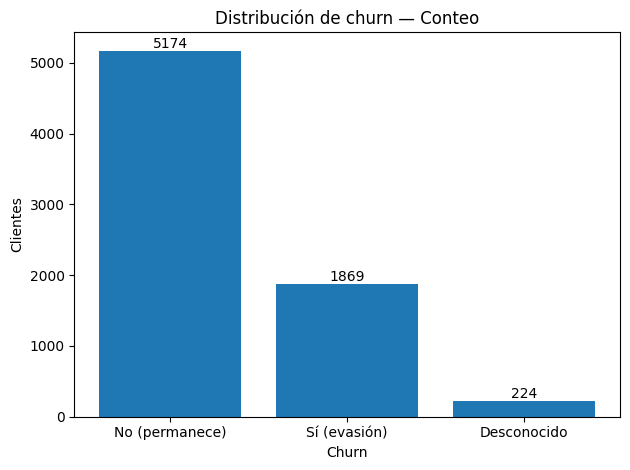

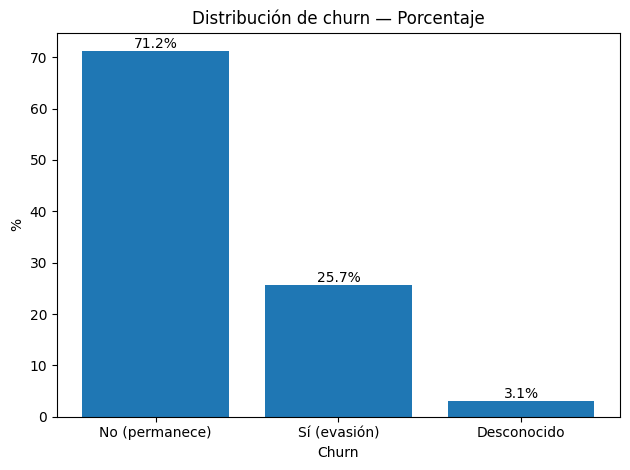

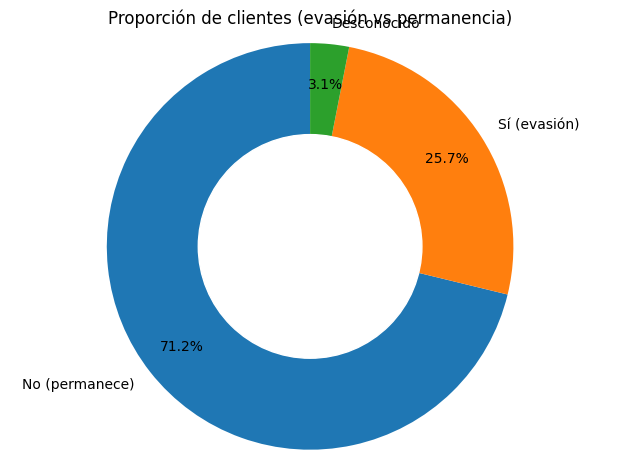

In [69]:
#Grafico
import matplotlib.pyplot as plt


# 1) Elegir DF disponible
base = None
for name in ["df_tr", "df_clean", "df"]:
    if name in globals():
        base = globals()[name].copy()
        break
assert base is not None, "No encuentro df_tr/df_clean/df."

# 2) Serie objetivo 0/1 permitiendo NA
def get_churn_series(df):
    cand = [c for c in ["evasión_flag","evasion_flag","churn_flag","churn"] if c in df.columns]
    assert cand, "No encontré columna de churn."
    s = df[cand[0]].copy()
    if pd.api.types.is_numeric_dtype(s):
        s = pd.to_numeric(s, errors="coerce").where(lambda x: x.isin([0,1]), np.nan)
    else:
        s = (s.astype(str).str.strip().str.lower()
               .map({"yes":1,"y":1,"si":1,"sí":1,"true":1,"1":1,
                     "no":0,"n":0,"false":0,"0":0}))
    return s.astype("Int64")

y = get_churn_series(base)

# 3) Conteos (incluye NA como "Desconocido")
n0, n1, n_na = int((y==0).sum()), int((y==1).sum()), int(y.isna().sum())
labels = ["No (permanece)", "Sí (evasión)"] + (["Desconocido"] if n_na>0 else [])
vals   = [n0, n1] + ([n_na] if n_na>0 else [])
percs  = (np.array(vals)/sum(vals)*100).round(2)

# 4) Barras (conteo)
plt.figure()
plt.bar(labels, vals)
plt.title("Distribución de churn — Conteo")
plt.xlabel("Churn"); plt.ylabel("Clientes")
for i,v in enumerate(vals): plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 5) Barras (porcentaje)
plt.figure()
plt.bar(labels, percs)
plt.title("Distribución de churn — Porcentaje")
plt.xlabel("Churn"); plt.ylabel("%")
for i,v in enumerate(percs): plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 6) Donut (opcional, solo mostrar)
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(vals, labels=labels, autopct="%1.1f%%", startangle=90, pctdistance=0.8)
circle = plt.Circle((0,0), 0.55, color="white"); ax.add_artist(circle)
ax.axis("equal"); ax.set_title("Proporción de clientes (evasión vs permanencia)")
plt.tight_layout()
plt.show()

In [70]:
# serie objetivo robusta (0/1 con NA permitidos)
def get_churn_series(df):
    cand = [c for c in ["evasión_flag","evasion_flag","churn_flag","churn"] if c in df.columns]
    assert cand, "No encontré columna de churn."
    s = df[cand[0]].copy()
    if pd.api.types.is_numeric_dtype(s):
        s = pd.to_numeric(s, errors="coerce").where(lambda x: x.isin([0,1]), np.nan)
    else:
        s = (s.astype(str).str.strip().str.lower()
               .map({"yes":1,"y":1,"si":1,"sí":1,"true":1,"1":1,
                     "no":0,"n":0,"false":0,"0":0}))
    return s.astype("Int64")

base["__churn__"] = get_churn_series(base)

In [72]:
def churn_table(df, ycol, col, min_count=10, include_na=True):
    s = df[col].copy()
    if not include_na:
        s = s.fillna("Desconocido")
    g = (pd.concat([s, df[ycol]], axis=1)
           .groupby(col, dropna=include_na)[ycol]
           .agg(churn_rate="mean", churned="sum", total="count"))
    g["churn_rate"] = (g["churn_rate"]*100).round(2)  # en %
    g["share"] = (g["total"]/g["total"].sum()*100).round(2)
    g = g.sort_values(["churn_rate","total"], ascending=[False, False])
    if min_count:
        g = g[g["total"] >= min_count]
    return g

def plot_churn_by(df, ycol, col, top=10, min_count=10):
    tab = churn_table(df, ycol, col, min_count=min_count).head(top)
    if tab.empty:
        print(f"[{col}] sin datos suficientes."); return
    plt.figure()
    tab["churn_rate"].iloc[::-1].plot(kind="barh")  # invertimos para ver mayor arriba
    plt.title(f"Churn (%) por {col}  — top {len(tab)}")
    plt.xlabel("Churn (%)"); plt.ylabel(col)
    # anotar conteos
    for i, (cat, row) in enumerate(tab.iloc[::-1].iterrows()):
        plt.text(row["churn_rate"]+0.5, i, f" n={int(row['total'])}", va="center")
    plt.tight_layout(); plt.show()
    display(tab)

In [73]:
# alias útiles para este dataset
aliases = [
    ["gender","genero"],
    ["contract","tipo_contrato"],
    ["paymentmethod","metodo_pago"],
    ["internetservice","servicio_internet"],
    ["paperlessbilling","facturacion_sin_papel"],
    ["phoneservice","servicio_telefonico"],
    ["multiplelines","multiples_lineas"],
    ["onlinesecurity","seguridad_en_linea"],
    ["onlinebackup","respaldo_en_linea"],
    ["deviceprotection","proteccion_dispositivos"],
    ["techsupport","soporte_tecnico"],
    ["streamingtv","streaming_tv"],
    ["streamingmovies","streaming_peliculas"],
]

def pick(cols):  # toma el primero que exista
    for c in cols:
        if c in base.columns: return c
    return None

cand_cols = [pick(a) for a in aliases]
cand_cols = [c for c in cand_cols if c is not None]

# agrega numéricas de baja cardinalidad (banderas 0/1) como categóricas
low_card_nums = [c for c in base.select_dtypes(include=[np.number]).columns
                 if c != "__churn__" and base[c].nunique(dropna=False) <= 5]
cat_cols = list(dict.fromkeys(cand_cols + low_card_nums))  # sin duplicados
cat_cols

['gender',
 'contract',
 'paymentmethod',
 'internetservice',
 'paperlessbilling',
 'phoneservice',
 'multiplelines',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'seniorcitizen',
 'churn_flag',
 'has_fiber',
 'contract_mtm']


============ gender ============


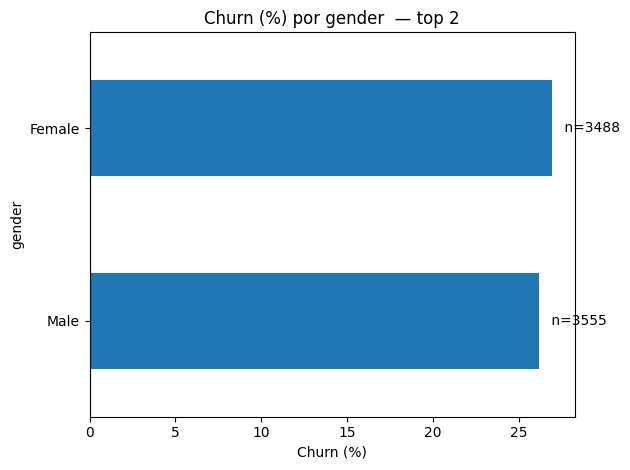

,churn_rate,churned,total,share
gender,,,,
Female,26.92,939,3488,49.52
Male,26.16,930,3555,50.48



============ contract ============


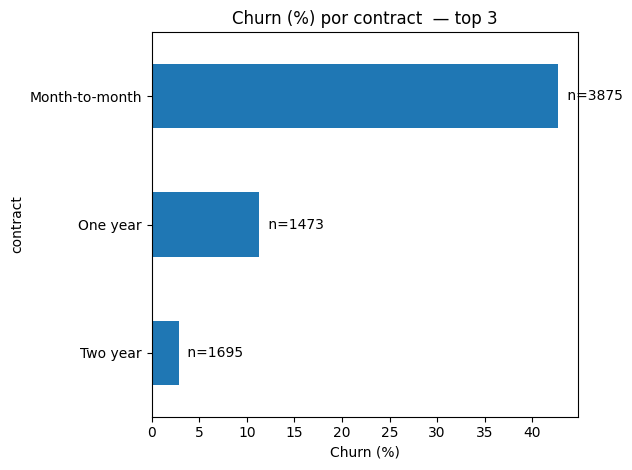

,churn_rate,churned,total,share
contract,,,,
Month-to-month,42.71,1655,3875,55.02
One year,11.27,166,1473,20.91
Two year,2.83,48,1695,24.07



============ paymentmethod ============


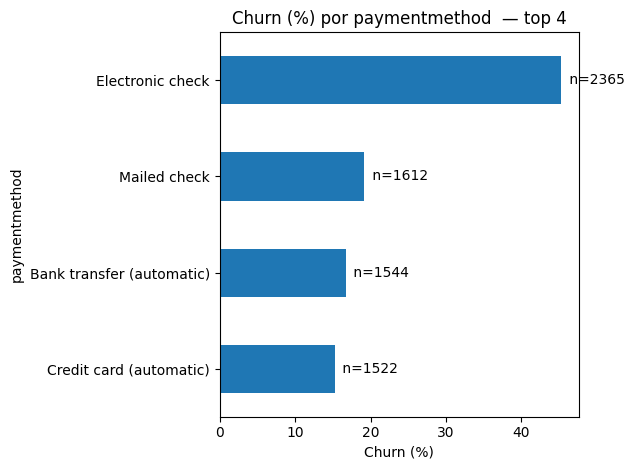

,churn_rate,churned,total,share
paymentmethod,,,,
Electronic check,45.29,1071,2365,33.58
Mailed check,19.11,308,1612,22.89
Bank transfer (automatic),16.71,258,1544,21.92
Credit card (automatic),15.24,232,1522,21.61



============ internetservice ============


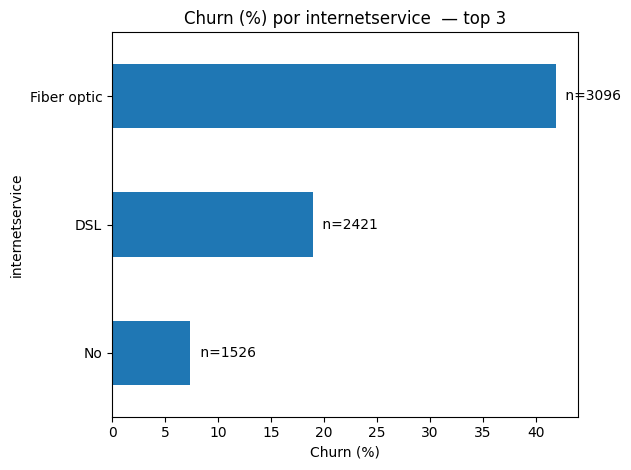

,churn_rate,churned,total,share
internetservice,,,,
Fiber optic,41.89,1297,3096,43.96
DSL,18.96,459,2421,34.37
No,7.4,113,1526,21.67



============ paperlessbilling ============


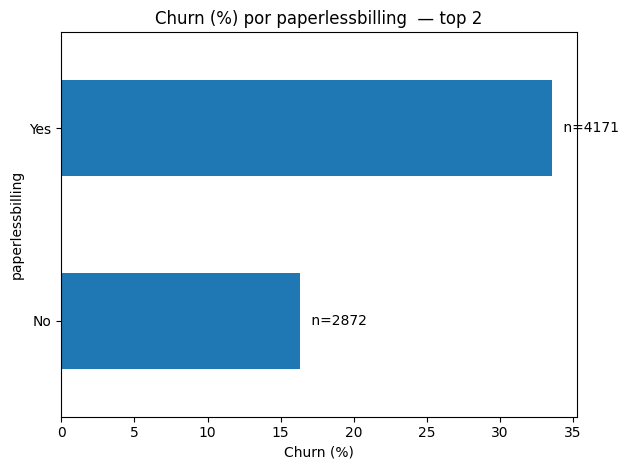

,churn_rate,churned,total,share
paperlessbilling,,,,
Yes,33.57,1400,4171,59.22
No,16.33,469,2872,40.78



============ phoneservice ============


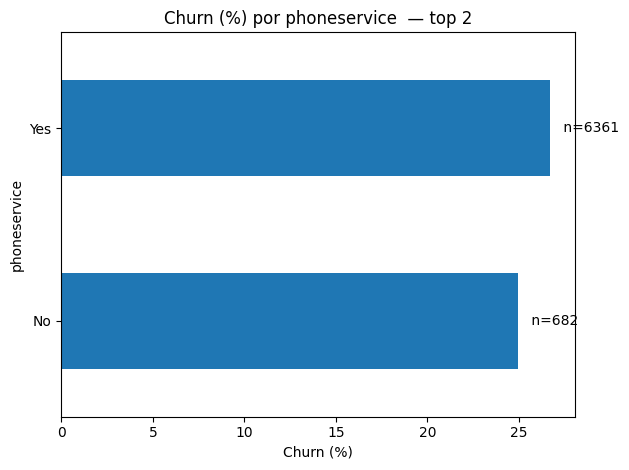

,churn_rate,churned,total,share
phoneservice,,,,
Yes,26.71,1699,6361,90.32
No,24.93,170,682,9.68



============ multiplelines ============


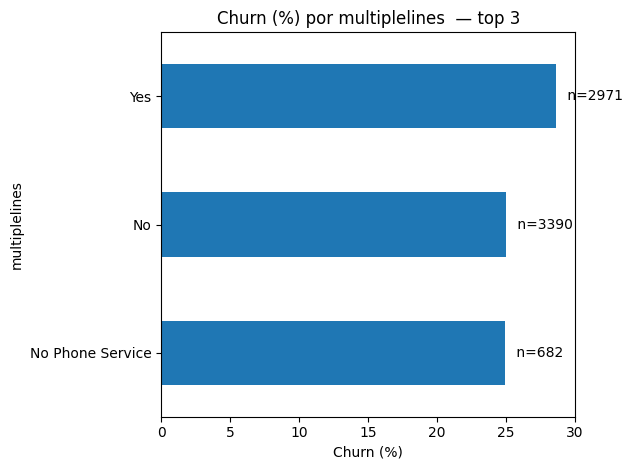

,churn_rate,churned,total,share
multiplelines,,,,
Yes,28.61,850,2971,42.18
No,25.04,849,3390,48.13
No Phone Service,24.93,170,682,9.68



============ onlinesecurity ============


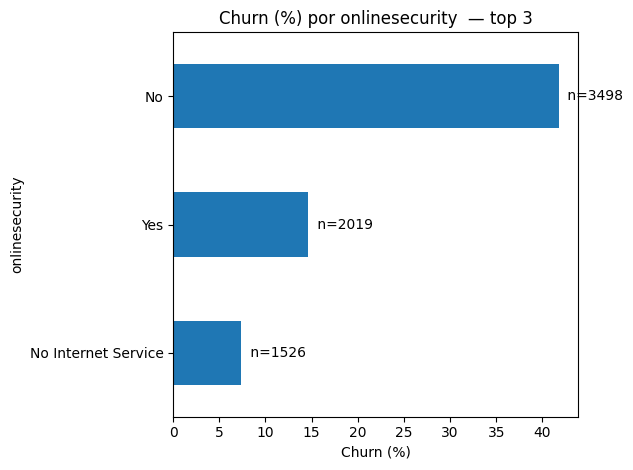

,churn_rate,churned,total,share
onlinesecurity,,,,
No,41.77,1461,3498,49.67
Yes,14.61,295,2019,28.67
No Internet Service,7.4,113,1526,21.67



============ onlinebackup ============


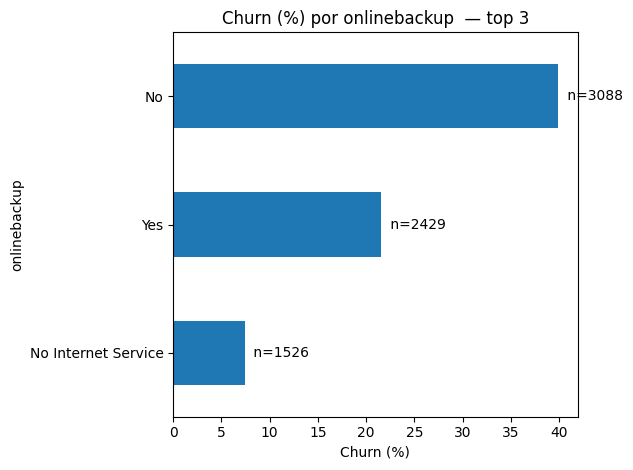

,churn_rate,churned,total,share
onlinebackup,,,,
No,39.93,1233,3088,43.84
Yes,21.53,523,2429,34.49
No Internet Service,7.4,113,1526,21.67



============ deviceprotection ============


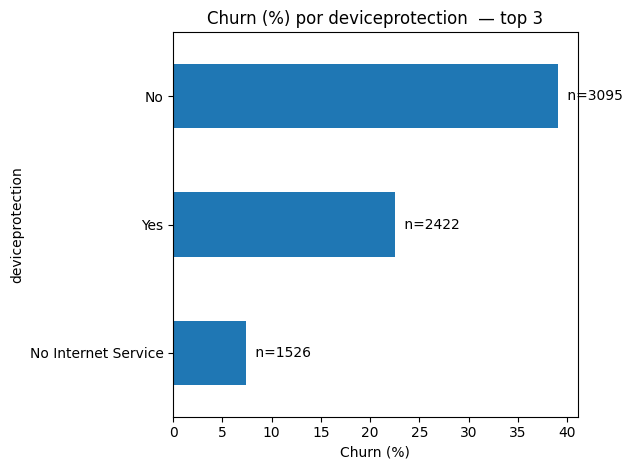

,churn_rate,churned,total,share
deviceprotection,,,,
No,39.13,1211,3095,43.94
Yes,22.5,545,2422,34.39
No Internet Service,7.4,113,1526,21.67



============ techsupport ============


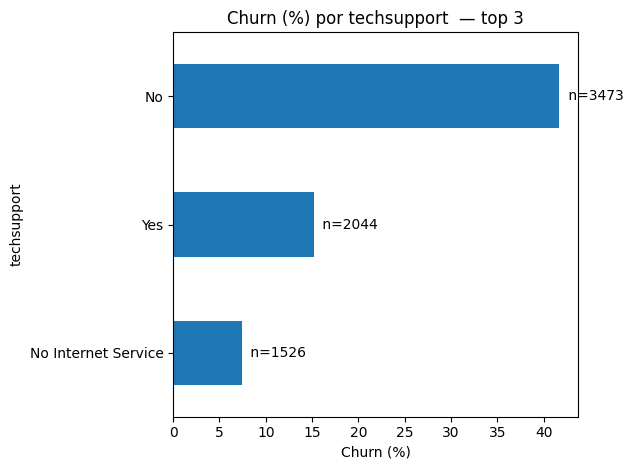

,churn_rate,churned,total,share
techsupport,,,,
No,41.64,1446,3473,49.31
Yes,15.17,310,2044,29.02
No Internet Service,7.4,113,1526,21.67



============ streamingtv ============


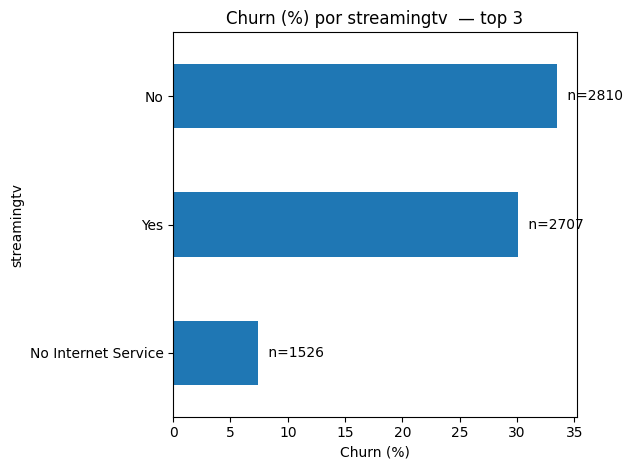

,churn_rate,churned,total,share
streamingtv,,,,
No,33.52,942,2810,39.9
Yes,30.07,814,2707,38.44
No Internet Service,7.4,113,1526,21.67



============ streamingmovies ============


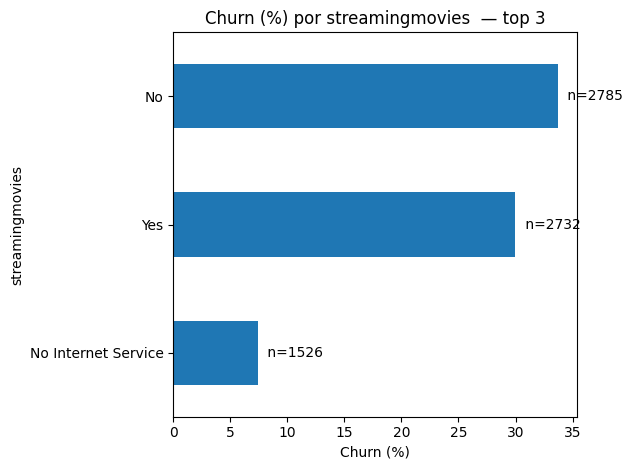

,churn_rate,churned,total,share
streamingmovies,,,,
No,33.68,938,2785,39.54
Yes,29.94,818,2732,38.79
No Internet Service,7.4,113,1526,21.67



============ seniorcitizen ============


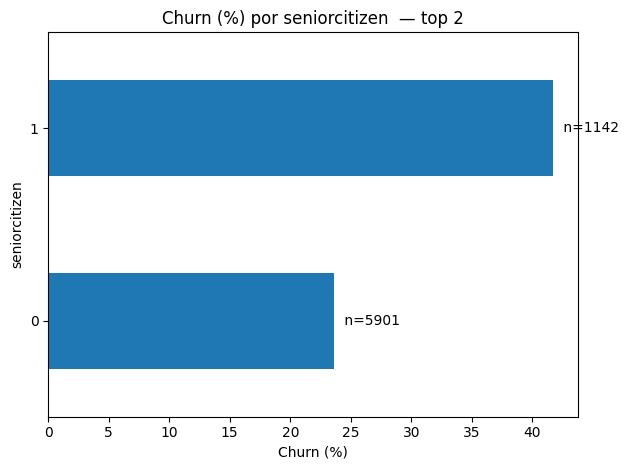

,churn_rate,churned,total,share
seniorcitizen,,,,
1,41.68,476,1142,16.21
0,23.61,1393,5901,83.79



============ churn_flag ============


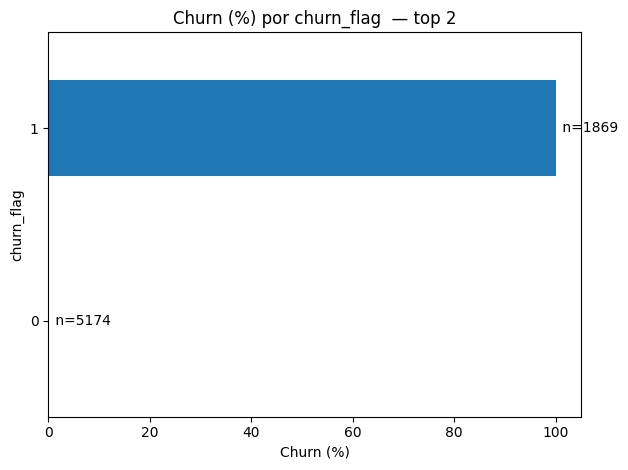

,churn_rate,churned,total,share
churn_flag,,,,
1,100.0,1869,1869,26.54
0,0.0,0,5174,73.46



============ has_fiber ============


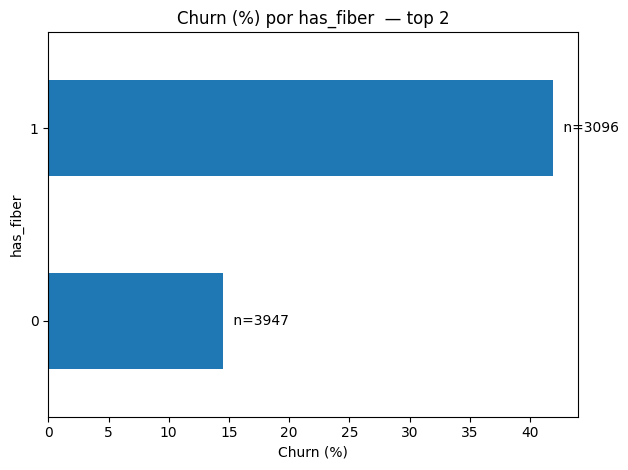

,churn_rate,churned,total,share
has_fiber,,,,
1,41.89,1297,3096,43.96
0,14.49,572,3947,56.04



============ contract_mtm ============


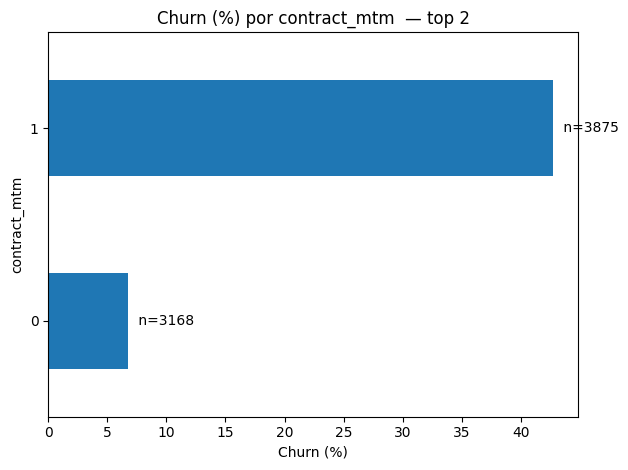

,churn_rate,churned,total,share
contract_mtm,,,,
1,42.71,1655,3875,55.02
0,6.76,214,3168,44.98


In [74]:
for col in cat_cols:
    print("\n" + "="*12, col, "="*12)
    plot_churn_by(base, "__churn__", col, top=10, min_count=10)

In [75]:
def bin_numeric(s: pd.Series, k=4, strategy="quantile"):
    """Devuelve etiquetas de bins legibles."""
    s = pd.to_numeric(s, errors="coerce")
    if strategy == "quantile":
        try:
            binned = pd.qcut(s, q=k, duplicates="drop")
        except ValueError:
            # si hay pocos valores distintos, cae a bins iguales
            binned = pd.cut(s, bins=min(k, s.nunique(dropna=True)))
    else:
        binned = pd.cut(s, bins=k)
    # etiquetas cortas
    return binned.astype(str)

def churn_counts_by_bin(df, num_col, ycol="__churn__", k=4, min_count=10):
    temp = df[[num_col, ycol]].copy()
    temp = temp[temp[ycol].notna()]                  # ignorar churn NA
    temp["bin"] = bin_numeric(temp[num_col], k=k)    # crea bins
    tab = (temp.groupby(["bin", ycol]).size()
                .unstack(fill_value=0)
                .rename(columns={0:"No (permanece)", 1:"Sí (evasión)"}))
    tab["total"] = tab.sum(axis=1)
    tab = tab[tab["total"] >= min_count].sort_index()
    # churn rate por bin (por si quieres tabla)
    tab["churn_%"] = (tab["Sí (evasión)"] / tab["total"] * 100).round(2)
    return tab

def plot_counts_by_bin(tab, num_col):
    """Barras lado a lado por bin de la variable numérica."""
    if tab.empty:
        print(f"[{num_col}] sin datos suficientes."); return
    x = np.arange(len(tab))
    w = 0.4
    plt.figure()
    plt.bar(x - w/2, tab["No (permanece)"], width=w, label="No (permanece)")
    plt.bar(x + w/2, tab["Sí (evasión)"], width=w, label="Sí (evasión)")
    plt.xticks(x, tab.index, rotation=45, ha="right")
    plt.title(f"Conteo de churn por rangos de {num_col}")
    plt.xlabel(f"{num_col} (binned)"); plt.ylabel("Cantidad de clientes")
    plt.legend()
    # anotar totals
    for i, v in enumerate(tab["Sí (evasión)"]):
        plt.text(i + w/2, v, str(int(v)), ha="center", va="bottom")
    for i, v in enumerate(tab["No (permanece)"]):
        plt.text(i - w/2, v, str(int(v)), ha="center", va="bottom")
    plt.tight_layout()
    plt.show()
    display(tab)

Numéricas a analizar: ['totalcharges', 'monthlycharges', 'tenure', 'bill_gap', 'seniorcitizen', 'churn_flag', 'has_fiber']

============ totalcharges ============


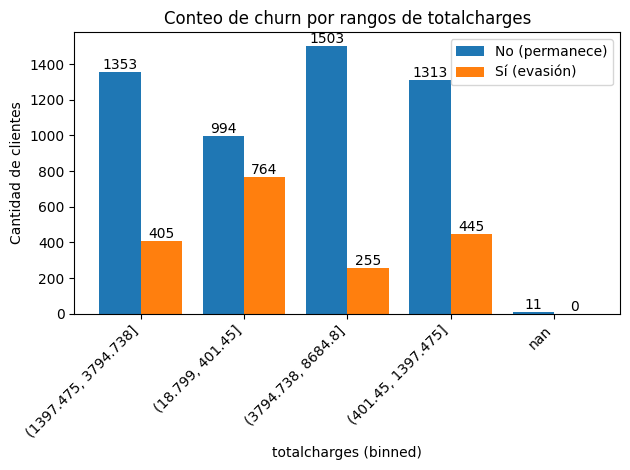

__churn__,No (permanece),Sí (evasión),total,churn_%
bin,,,,
"(1397.475, 3794.738]",1353,405,1758,23.04
"(18.799, 401.45]",994,764,1758,43.46
"(3794.738, 8684.8]",1503,255,1758,14.51
"(401.45, 1397.475]",1313,445,1758,25.31
nan,11,0,11,0.00



============ monthlycharges ============


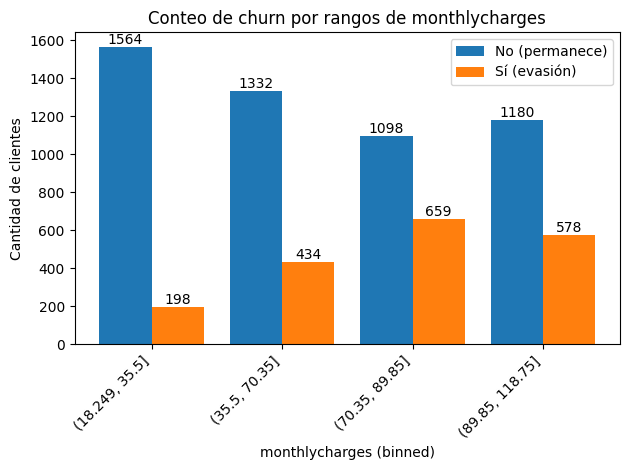

__churn__,No (permanece),Sí (evasión),total,churn_%
bin,,,,
"(18.249, 35.5]",1564,198,1762,11.24
"(35.5, 70.35]",1332,434,1766,24.58
"(70.35, 89.85]",1098,659,1757,37.51
"(89.85, 118.75]",1180,578,1758,32.88



============ tenure ============


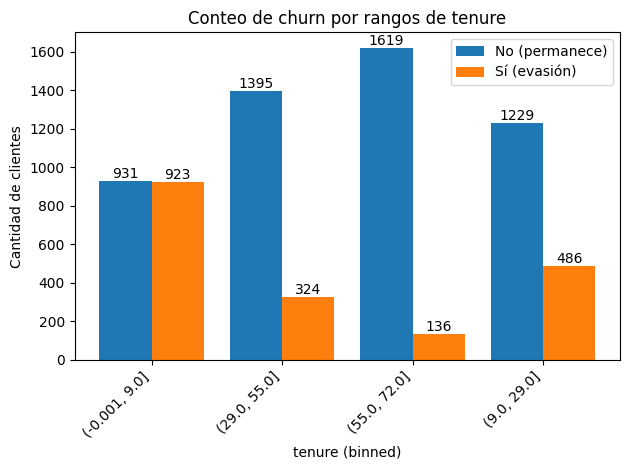

__churn__,No (permanece),Sí (evasión),total,churn_%
bin,,,,
"(-0.001, 9.0]",931,923,1854,49.78
"(29.0, 55.0]",1395,324,1719,18.85
"(55.0, 72.0]",1619,136,1755,7.75
"(9.0, 29.0]",1229,486,1715,28.34



============ bill_gap ============


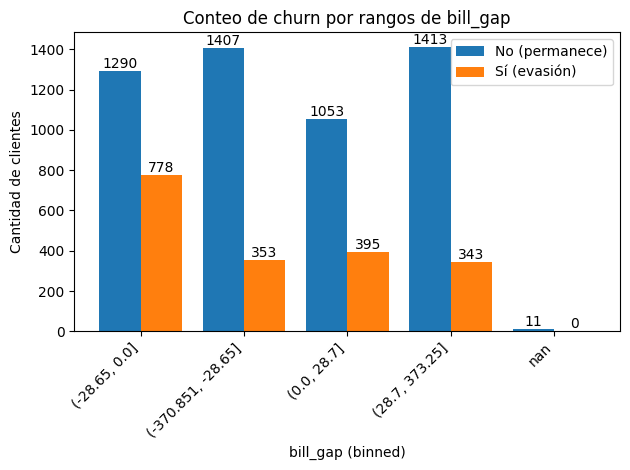

__churn__,No (permanece),Sí (evasión),total,churn_%
bin,,,,
"(-28.65, 0.0]",1290,778,2068,37.62
"(-370.851, -28.65]",1407,353,1760,20.06
"(0.0, 28.7]",1053,395,1448,27.28
"(28.7, 373.25]",1413,343,1756,19.53
nan,11,0,11,0.00



============ seniorcitizen ============


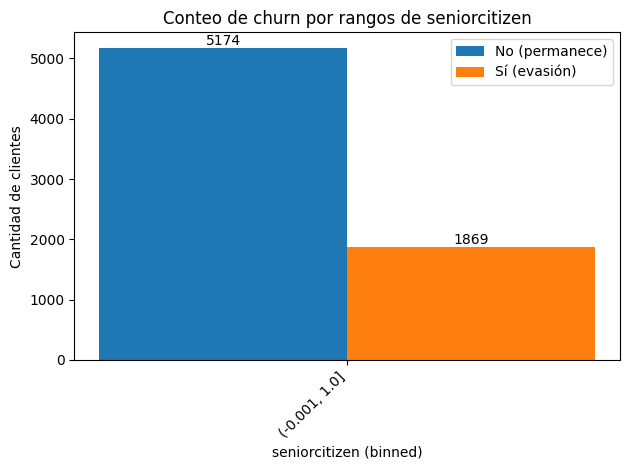

__churn__,No (permanece),Sí (evasión),total,churn_%
bin,,,,
"(-0.001, 1.0]",5174,1869,7043,26.54



============ churn_flag ============


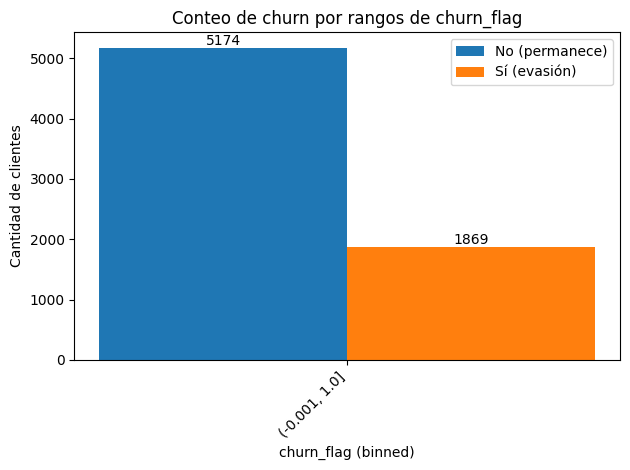

__churn__,No (permanece),Sí (evasión),total,churn_%
bin,,,,
"(-0.001, 1.0]",5174,1869,7043,26.54



============ has_fiber ============


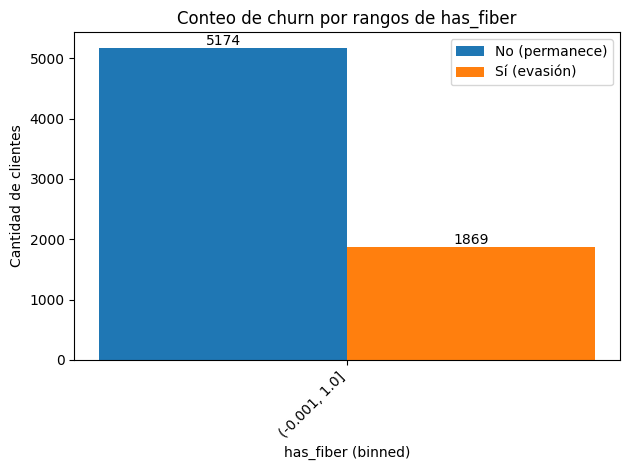

__churn__,No (permanece),Sí (evasión),total,churn_%
bin,,,,
"(-0.001, 1.0]",5174,1869,7043,26.54


In [76]:
# candidatos típicos (usa los que existan)
candidatos = [
    "totalcharges","cargos_totales",
    "monthlycharges","cargos_mensuales",
    "tenure","antiguedad_meses",
    "Cuentas_Diarias","cargos_diarios",
    "bill_gap"
]
num_cols = [c for c in candidatos if c in base.columns]
# agrega cualquier otra numérica útil (sin contar churn)
extra_nums = [c for c in base.select_dtypes(include=[np.number]).columns
              if c not in num_cols + ["__churn__"]]
# nos quedamos con pocas extra para no saturar
num_cols = list(dict.fromkeys(num_cols + extra_nums[:3]))  # sin duplicados
print("Numéricas a analizar:", num_cols)

for col in num_cols:
    print("\n" + "="*12, col, "="*12)
    t = churn_counts_by_bin(base, col, ycol="__churn__", k=4, min_count=10)
    plot_counts_by_bin(t, col)


#📄Informe final

In [77]:
# ---- categóricas
def churn_table_cat(df, col, y="__churn__", min_count=10):
    t = (df.groupby(col, dropna=False)[y]
           .agg(churn_rate="mean", churned="sum", total="count"))
    t["churn_rate"] = (t["churn_rate"]*100).round(2)
    t["share"] = (t["total"]/t["total"].sum()*100).round(2)
    t = t[t["total"] >= min_count].sort_values(["churn_rate","total"], ascending=[False, False])
    return t

def plot_churn_cat(df, col, y="__churn__", top=10, min_count=10, title=None):
    t = churn_table_cat(df, col, y, min_count).head(top)
    if t.empty:
        print(f"[{col}] sin datos suficientes."); return t
    plt.figure()
    t["churn_rate"].iloc[::-1].plot(kind="barh")
    plt.title(title or f"Churn (%) por {col}")
    plt.xlabel("Churn (%)"); plt.ylabel(col)
    for i, (cat, row) in enumerate(t.iloc[::-1].iterrows()):
        plt.text(row["churn_rate"]+0.5, i, f"n={int(row['total'])}", va="center")
    plt.tight_layout(); plt.show()
    return t

# ---- numéricas (binning por cuantiles)
def bin_numeric(s: pd.Series, k=4):
    s = pd.to_numeric(s, errors="coerce")
    try:
        b = pd.qcut(s, q=k, duplicates="drop")
    except ValueError:
        b = pd.cut(s, bins=min(k, s.nunique(dropna=True)))
    return b.astype(str)

def churn_table_num(df, col, y="__churn__", k=4, min_count=10):
    tmp = df[[col, y]].dropna(subset=[y]).copy()
    tmp["bin"] = bin_numeric(tmp[col], k=k)
    t = (tmp.groupby(["bin", y]).size()
             .unstack(fill_value=0)
             .rename(columns={0:"No",1:"Sí"}))
    t["total"] = t.sum(axis=1)
    t = t[t["total"] >= min_count].sort_index()
    t["churn_%"] = (t["Sí"]/t["total"]*100).round(2)
    return t

def plot_counts_num(tab, col):
    if tab.empty:
        print(f"[{col}] sin datos suficientes."); return
    x = np.arange(len(tab)); w = 0.4
    plt.figure()
    plt.bar(x-w/2, tab["No"], width=w, label="No")
    plt.bar(x+w/2, tab["Sí"], width=w, label="Sí")
    plt.xticks(x, tab.index, rotation=45, ha="right")
    plt.title(f"Conteo de churn por rangos de {col}")
    plt.xlabel(f"{col} (bins)"); plt.ylabel("Clientes"); plt.legend()
    for i,v in enumerate(tab["Sí"]): plt.text(i+w/2, v, str(int(v)), ha="center", va="bottom")
    for i,v in enumerate(tab["No"]): plt.text(i-w/2, v, str(int(v)), ha="center", va="bottom")
    plt.tight_layout(); plt.show()



# Informe — Churn de Clientes (Telecom X)

**Objetivo.** Analizar la evasión (*churn*) para entender qué factores explican que los clientes se den de baja y
apoyar decisiones para **reducir la evasión**.

**Alcance.** Se importó el dataset, se limpió/estandarizó, se construyeron variables y se realizaron análisis
descriptivos/EDA para identificar patrones clave.


## Limpieza y Tratamiento de Datos
- Normalización de textos y mapeo **Sí/No** a valores consistentes.
- Conversión a numérico de **cargos** y **antigüedad**, con coerción segura.
- Estandarización de **servicio de internet** (DSL/Fiber optic/No) y coherencia de add-ons.
- Coherencia de **telefonía**: sin teléfono ⇒ múltiples líneas = *No Phone Service*.
- Creación de variable objetivo binaria **churn_flag (0/1)**.

### KPIs
- **Total clientes**: 7267
- **Evasión (conocidos) %**: 26.54
- **Desconocidos en churn**: 224

## Análisis Exploratorio de Datos

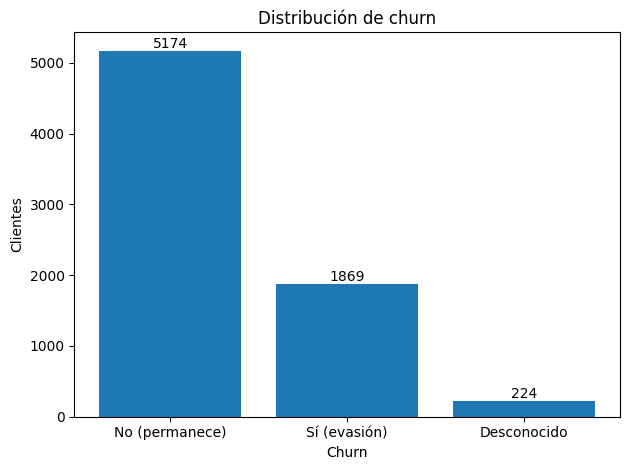

### Churn por **contract**

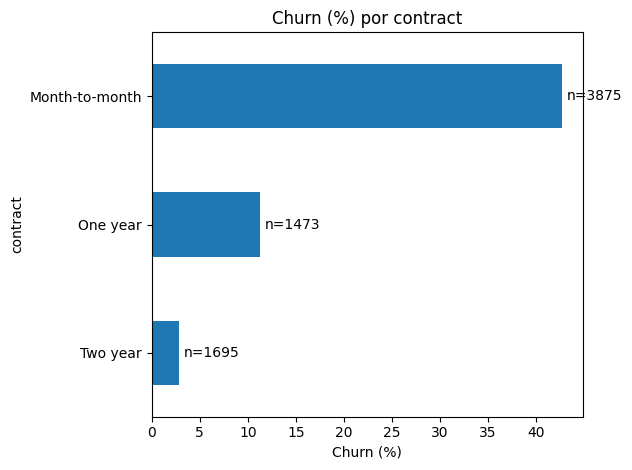

### Churn por **paymentmethod**

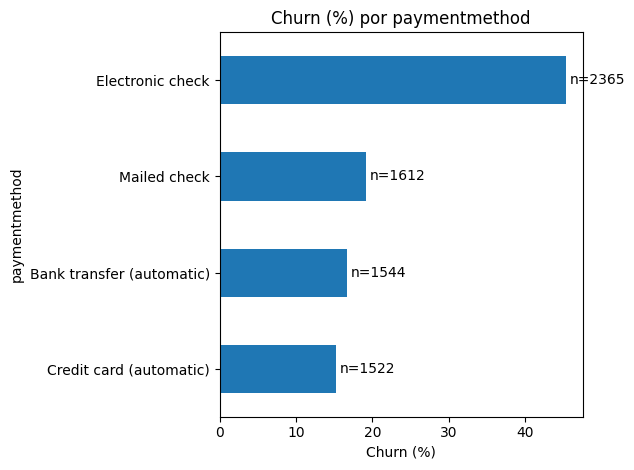

### Churn por **internetservice**

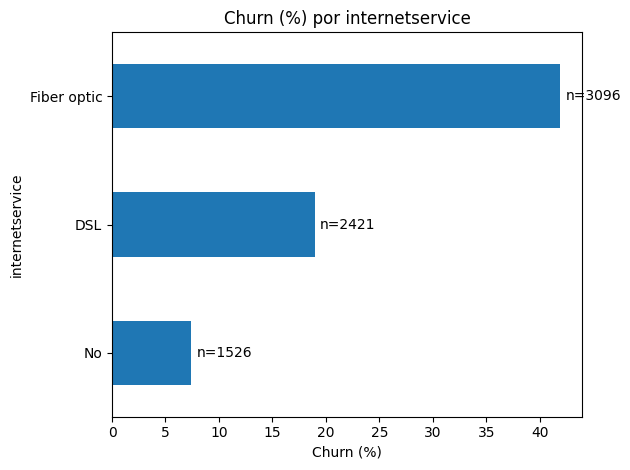

### Churn por **paperlessbilling**

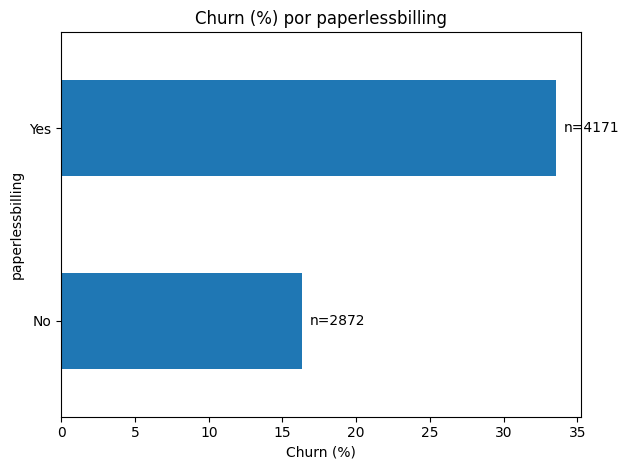

### Conteo por rangos de **tenure**

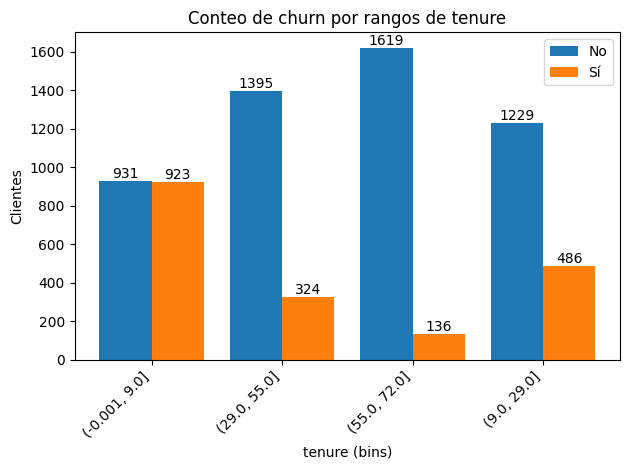

### Conteo por rangos de **monthlycharges**

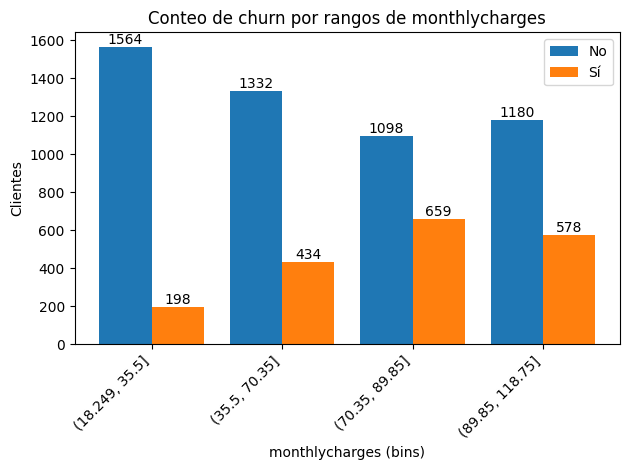

### Conteo por rangos de **totalcharges**

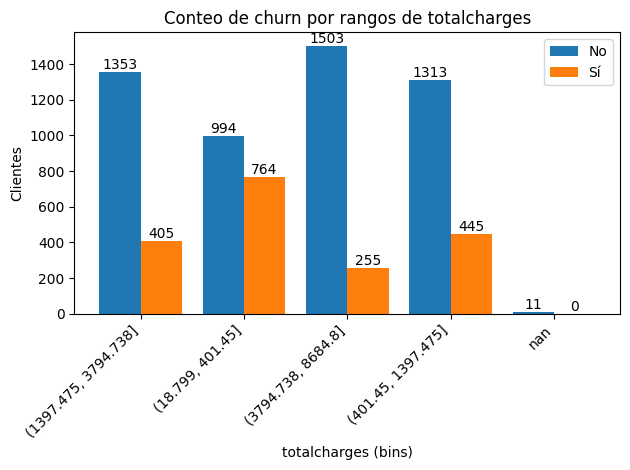

## Conclusiones e Insights
- **Contrato**: mayor churn en *Month-to-month* (42.71%), menor en *Two year* (2.83%).
- **Antigüedad**: los tramos bajos exhiben mayor churn (49.78% vs 28.34% en los más altos).
- **Método de pago** con mayor churn: *Electronic check* (45.29%).
- **Cargos mensuales**: el bin *(70.35, 89.85]* presenta el mayor churn (37.51%).

## Recomendaciones
- Incentivar el **cambio de contrato** de *Month-to-month* a anual/bi-anual con descuentos o beneficios.
- Diseñar acciones de **onboarding y retención temprana** para clientes con **baja antigüedad** (primeros 3–6 meses).
- Revisar **política de precios/paquetes** para tramos con **cargos mensuales altos**.
- Promover **métodos de pago automáticos** (transferencia/crédito) si el método con mayor churn es *Electronic check*.
- Ofrecer **servicios de valor** (seguridad, soporte) a segmentos sensibles para aumentar *stickiness*.

In [78]:
from IPython.display import display, Markdown

# ====== INTRODUCCIÓN ======
intro = """
# Informe — Churn de Clientes (Telecom X)

**Objetivo.** Analizar la evasión (*churn*) para entender qué factores explican que los clientes se den de baja y
apoyar decisiones para **reducir la evasión**.

**Alcance.** Se importó el dataset, se limpió/estandarizó, se construyeron variables y se realizaron análisis
descriptivos/EDA para identificar patrones clave.
"""
display(Markdown(intro))

# ====== LIMPIEZA Y TRATAMIENTO (resumen textual, inferido del pipeline que venimos usando) ======
pasos = []
if any(c in base.columns for c in ["partner","dependents","paperlessbilling"]):
    pasos.append("- Normalización de textos y mapeo **Sí/No** a valores consistentes.")
if any(c in base.columns for c in ["monthlycharges","totalcharges","tenure"]):
    pasos.append("- Conversión a numérico de **cargos** y **antigüedad**, con coerción segura.")
if "internetservice" in base.columns:
    pasos.append("- Estandarización de **servicio de internet** (DSL/Fiber optic/No) y coherencia de add-ons.")
if "phoneservice" in base.columns and "multiplelines" in base.columns:
    pasos.append("- Coherencia de **telefonía**: sin teléfono ⇒ múltiples líneas = *No Phone Service*.")
if "Cuentas_Diarias" in base.columns or "cargos_diarios" in base.columns:
    pasos.append("- Derivación de **cargos diarios** a partir de cargos mensuales.")
pasos.append("- Creación de variable objetivo binaria **churn_flag (0/1)**.")
display(Markdown("## Limpieza y Tratamiento de Datos\n" + "\n".join(pasos)))

# ====== KPIs básicos ======
y = base["__churn__"]
kpi = {
    "Total clientes": int(len(base)),
    "Evasión (conocidos) %": round(y.dropna().mean()*100, 2),
    "Desconocidos en churn": int(y.isna().sum()),
}
display(Markdown("### KPIs\n" + "\n".join([f"- **{k}**: {v}" for k,v in kpi.items()])))

# ====== ANÁLISIS EXPLORATORIO ======
display(Markdown("## Análisis Exploratorio de Datos"))

# 3.1 Distribución de churn
vc = y.value_counts(dropna=False).reindex([0,1,np.nan], fill_value=0)
labels = ["No (permanece)","Sí (evasión)"] + (["Desconocido"] if vc.loc[np.nan]>0 else [])
vals   = [int(vc.get(0,0)), int(vc.get(1,0))] + ([int(vc.get(np.nan,0))] if vc.loc[np.nan]>0 else [])
plt.figure()
plt.bar(labels, vals); plt.title("Distribución de churn"); plt.xlabel("Churn"); plt.ylabel("Clientes")
for i,v in enumerate(vals): plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout(); plt.show()

# 3.2 Categóricas clave
cat_candidates = [c for c in [
    "contract","tipo_contrato",
    "paymentmethod","metodo_pago",
    "internetservice","servicio_internet",
    "paperlessbilling","facturacion_sin_papel"
] if c in base.columns]

results_cat = {}
for col in cat_candidates:
    display(Markdown(f"### Churn por **{col}**"))
    results_cat[col] = plot_churn_cat(base, col, "__churn__", top=10, min_count=10)

# 3.3 Numéricas clave (bins)
num_candidates = [c for c in [
    "tenure","antiguedad_meses",
    "monthlycharges","cargos_mensuales",
    "totalcharges","cargos_totales",
    "Cuentas_Diarias","cargos_diarios"
] if c in base.columns]

results_num = {}
for col in num_candidates:
    display(Markdown(f"### Conteo por rangos de **{col}**"))
    t = churn_table_num(base, col, "__churn__", k=4, min_count=10)
    plot_counts_num(t, col)
    results_num[col] = t

# ====== CONCLUSIONES E INSIGHTS (basadas en los resultados arriba) ======
insights = []

# Contrato
for key in ["contract","tipo_contrato"]:
    if key in results_cat and not results_cat[key].empty:
        top_row = results_cat[key].iloc[0]
        low_row = results_cat[key].iloc[-1]
        insights.append(f"- **Contrato**: mayor churn en *{results_cat[key].index[0]}* "
                        f"({top_row['churn_rate']}%), menor en *{results_cat[key].index[-1]}* "
                        f"({low_row['churn_rate']}%).")
        break

# Antigüedad
ten_col = "antiguedad_meses" if "antiguedad_meses" in results_num else ("tenure" if "tenure" in results_num else None)
if ten_col and not results_num[ten_col].empty:
    first = results_num[ten_col].iloc[0]["churn_%"]; last = results_num[ten_col].iloc[-1]["churn_%"]
    insights.append(f"- **Antigüedad**: los tramos bajos exhiben mayor churn ({first}% vs {last}% en los más altos).")

# Método de pago
for key in ["paymentmethod","metodo_pago"]:
    if key in results_cat and not results_cat[key].empty:
        top = results_cat[key].iloc[0]
        insights.append(f"- **Método de pago** con mayor churn: *{results_cat[key].index[0]}* "
                        f"({top['churn_rate']}%).")
        break

# Cargos mensuales
mc = "cargos_mensuales" if "cargos_mensuales" in results_num else ("monthlycharges" if "monthlycharges" in results_num else None)
if mc and not results_num[mc].empty:
    top_bin = results_num[mc]["churn_%"].idxmax()
    top_val = results_num[mc]["churn_%"].max()
    insights.append(f"- **Cargos mensuales**: el bin *{top_bin}* presenta el mayor churn ({top_val}%).")

display(Markdown("## Conclusiones e Insights\n" + ("\n".join(insights) if insights else "- (Completar con resultados del EDA)")))

# ====== RECOMENDACIONES (orientadas por insights) ======
recs = [
"- Incentivar el **cambio de contrato** de *Month-to-month* a anual/bi-anual con descuentos o beneficios.",
"- Diseñar acciones de **onboarding y retención temprana** para clientes con **baja antigüedad** (primeros 3–6 meses).",
"- Revisar **política de precios/paquetes** para tramos con **cargos mensuales altos**.",
"- Promover **métodos de pago automáticos** (transferencia/crédito) si el método con mayor churn es *Electronic check*.",
"- Ofrecer **servicios de valor** (seguridad, soporte) a segmentos sensibles para aumentar *stickiness*.",
]
display(Markdown("## Recomendaciones\n" + "\n".join(recs)))